# GOAL
1. Create a score for each article based on engagement, sentiment, richness, and quality.
2. Use the score to find the highest quality articles.
3. Analyze the features of the highest quality articles.
4. Determine which features are most important for designing a high quality article.



### Import libraries

In [41]:
# Core libraries
import pandas as pd
import requests
import zipfile
import io
import os

# Panda settings
pd.set_option('display.max_columns', None)

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

### Download and extract the data

#### Dataset background

The dataset contains 39,797 news articles published by Mashable between January 2013 and December 2016.

More information about the dataset can be found here: https://archive.ics.uci.edu/dataset/332/online+news+popularity

For details on the features, see the dataset description here: https://archive.ics.uci.edu/dataset/332/online+news+popularity/view


In [42]:
# URL of the file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip"

# Make sure the data folder exists
os.makedirs("webdata/data", exist_ok=True)

# Download the file
response = requests.get(url)

# Check if the download was successful
if response.status_code == 200:
    # Use BytesIO to read the content as a file-like object
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Extract all files to the "data" folder
        z.extractall("webdata/data")
    print("Download and extraction complete.")
else:
    print("Failed to download the file.")


Download and extraction complete.


### Inspect the data

In [43]:
df = pd.read_csv('webdata/data/OnlineNewsPopularity/OnlineNewsPopularity.csv')


In [44]:
df.shape

(39644, 61)

In [45]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


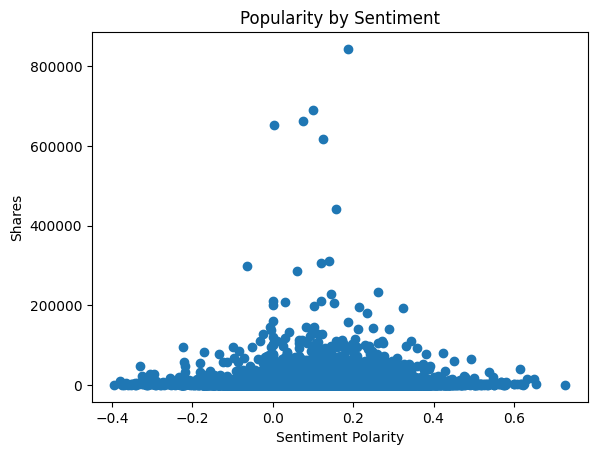

In [46]:
from matplotlib import pyplot as plt
plt.scatter(df[' global_sentiment_polarity'],df[' shares'])
plt.title('Popularity by Sentiment')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Shares')
plt.show()

### Create a health score for each article using key features



Pick the features to use.

In [47]:
score_features = [
    ' shares',  # Popularity
    ' global_sentiment_polarity',  # Overall sentiment
    ' global_rate_positive_words',  # Positivity
    ' avg_positive_polarity',  # Strength of positive sentiment
    ' num_hrefs',  # Number of links (engagement)
    ' num_imgs',  # Number of images (content richness)
    ' num_videos',  # Number of videos (content richness)
    ' average_token_length',  # Writing complexity
    ' n_tokens_content'  # Article length
]

Create a function to normalize values between 1 and 10

In [30]:
def normalize_to_scale(series):
    normalized = (series - series.min()) / (series.max() - series.min())  # First normalize to 0-1
    normalized = normalized ** 0.5  # Apply square root to spread out the values
    return (normalized * 9) + 1  # Scale to 1-10

Calculate the health score.

In [31]:
health_scores = pd.DataFrame()
for feature in score_features:
    if feature == ' shares':  # Give extra weight to shares
        health_scores[feature] = normalize_to_scale(news[feature]) * 1.5
    else:
        health_scores[feature] = normalize_to_scale(news[feature])

Calculate final health score (average of all normalized features).

In [32]:
news['health_score'] = health_scores.mean(axis=1)

In [33]:
news['health_score'] = normalize_to_scale(news['health_score'])

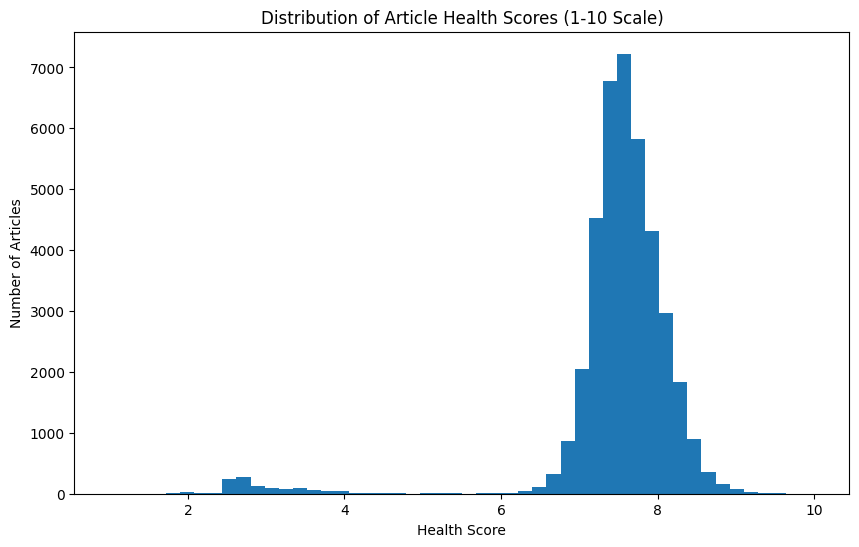

In [34]:
# Display distribution of health scores
plt.figure(figsize=(10, 6))
plt.hist(news['health_score'], bins=50)
plt.title('Distribution of Article Health Scores (1-10 Scale)')
plt.xlabel('Health Score')
plt.ylabel('Number of Articles')
plt.show()

In [35]:
# Show some example articles and their scores
print("\nTop articles by health score:")
sample_results = news[['url', 'health_score']].sort_values('health_score', ascending=False).head()
print(sample_results.round(2))  # Round to 2 decimal places for cleaner output


Top articles by health score:
                                                     url  health_score
18702  http://mashable.com/2014/01/12/first-photobomb...         10.00
24612  http://mashable.com/2014/05/03/joe-biden-comme...         10.00
9365     http://mashable.com/2013/07/03/low-cost-iphone/          9.80
19764  http://mashable.com/2014/02/02/snaps-super-bow...          9.58
24564  http://mashable.com/2014/05/02/hotel-associati...          9.58


In [38]:
news[score_features + ['health_score']]


,shares,global_sentiment_polarity,global_rate_positive_words,avg_positive_polarity,num_hrefs,num_imgs,num_videos,average_token_length,n_tokens_content,health_score
0,593,0.092562,0.045662,0.378636,4.0,1.0,0.0,4.680365,219.0,7.309702
1,711,0.148948,0.043137,0.286915,3.0,1.0,0.0,4.913725,255.0,7.259478
2,1500,0.323333,0.056872,0.495833,3.0,1.0,0.0,4.393365,211.0,7.662288
3,1200,0.100705,0.041431,0.385965,9.0,1.0,0.0,4.404896,531.0,7.474930
4,505,0.281003,0.074627,0.411127,19.0,20.0,0.0,4.682836,1072.0,8.435923
...,...,...,...,...,...,...,...,...,...,...
39639,1800,0.141964,0.037572,0.333791,9.0,1.0,1.0,4.523121,346.0,7.523900
39640,1900,0.194249,0.039634,0.374825,9.0,3.0,48.0,4.405488,328.0,8.425068
39641,1900,0.024609,0.033937,0.307273,24.0,12.0,1.0,5.076923,442.0,7.861995
39642,1100,-0.008066,0.020528,0.236851,10.0,1.0,0.0,4.975073,682.0,7.105981


In [40]:
# Put the health score in the original dataframe
news['health_score'] = news['health_score'].round(2)
news.head()


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,health_score
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0,496.0,496.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,7.31
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,7.26
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,918.0,918.0,918.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,7.66
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,7.47
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,545.0,16000.0,3151.157895,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,8.44
